# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models. In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository. https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.


# Import section

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

np.random.seed(2020)
#random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [2]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

# Gini index

In [4]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)


In [5]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [6]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [7]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

# Entropy

In [8]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [9]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [10]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [11]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [12]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [13]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [14]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [15]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [16]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7619047619047619


In [17]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8333333333333334


Now it's your turn to explore the various parameters of sklearn RandomForestClassifier and their influence on model quality.

# Homework part 1. RandomForestClassifier

Note: Consider accuracy as main metric of model performance on this dataset.

In [70]:
from sklearn.ensemble import RandomForestClassifier

Task 1 (0.5 points) Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='target'), df['target'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)


Task 2 (2 points). Apply 'greedy' hyperparameter tuning of RandomForestClassifier model. 'Greedy' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric.

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.

Here is one of the possible options for RandomForestClassifier:

Choose a decent value for number of trees using 'elbow' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not as much as before.
Pick up the best split criterion ('gini' / 'entropy') and then tune _maxdepth, _min_samplessplit, _min_samplesleaf.
Increase number of trees with best found parameters so far.
Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps if you observe a significant test metric improvement. Otherwise just stop and measure your best model result on validation set.

In [72]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feat_0   208 non-null    float64
 1   feat_1   208 non-null    float64
 2   feat_2   208 non-null    float64
 3   feat_3   208 non-null    float64
 4   feat_4   208 non-null    float64
 5   feat_5   208 non-null    float64
 6   feat_6   208 non-null    float64
 7   feat_7   208 non-null    float64
 8   feat_8   208 non-null    float64
 9   feat_9   208 non-null    float64
 10  feat_10  208 non-null    float64
 11  feat_11  208 non-null    float64
 12  feat_12  208 non-null    float64
 13  feat_13  208 non-null    float64
 14  feat_14  208 non-null    float64
 15  feat_15  208 non-null    float64
 16  feat_16  208 non-null    float64
 17  feat_17  208 non-null    float64
 18  feat_18  208 non-null    float64
 19  feat_19  208 non-null    float64
 20  feat_20  208 non-null    float64
 21  feat_21  208 non

In [74]:
#Скалируем данные
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

C:\Users\Irisha-PC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


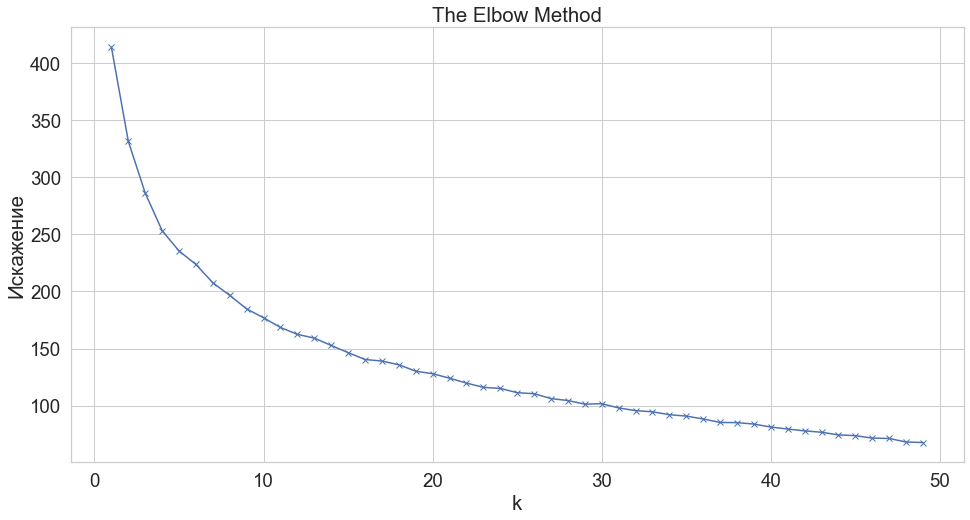

In [76]:
#Применим метод локтя
from sklearn.cluster import KMeans

distortions = []
K = range(1, 50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Искажение')
plt.title('The Elbow Method')
plt.show()

#Оптимальное значение k=10

In [38]:
#Выбор критерия
from sklearn.ensemble import RandomForestClassifier as RFC

model = RFC(n_estimators=10, criterion="gini")
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.8095238095238095

Gini accuracy score is: 0.8095238095238095


In [40]:
model = RFC(n_estimators=10, criterion="entropy")
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"Entropy accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7380952380952381

Entropy accuracy score is: 0.7380952380952381


In [68]:
#Создадим датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,300,39,2,sqrt,3,True,0.798684,1
1,1000,7,12,sqrt,2,True,0.790554,2
2,400,12,28,sqrt,2,False,0.782617,3
3,900,34,18,sqrt,11,True,0.782617,4
4,500,12,18,sqrt,13,False,0.782424,5
5,700,2,2,log2,11,True,0.782424,5
6,400,23,2,sqrt,14,False,0.782424,5
7,700,12,2,sqrt,13,False,0.782424,5
8,300,18,18,sqrt,13,True,0.782424,9
9,1000,7,34,sqrt,4,False,0.782230,10


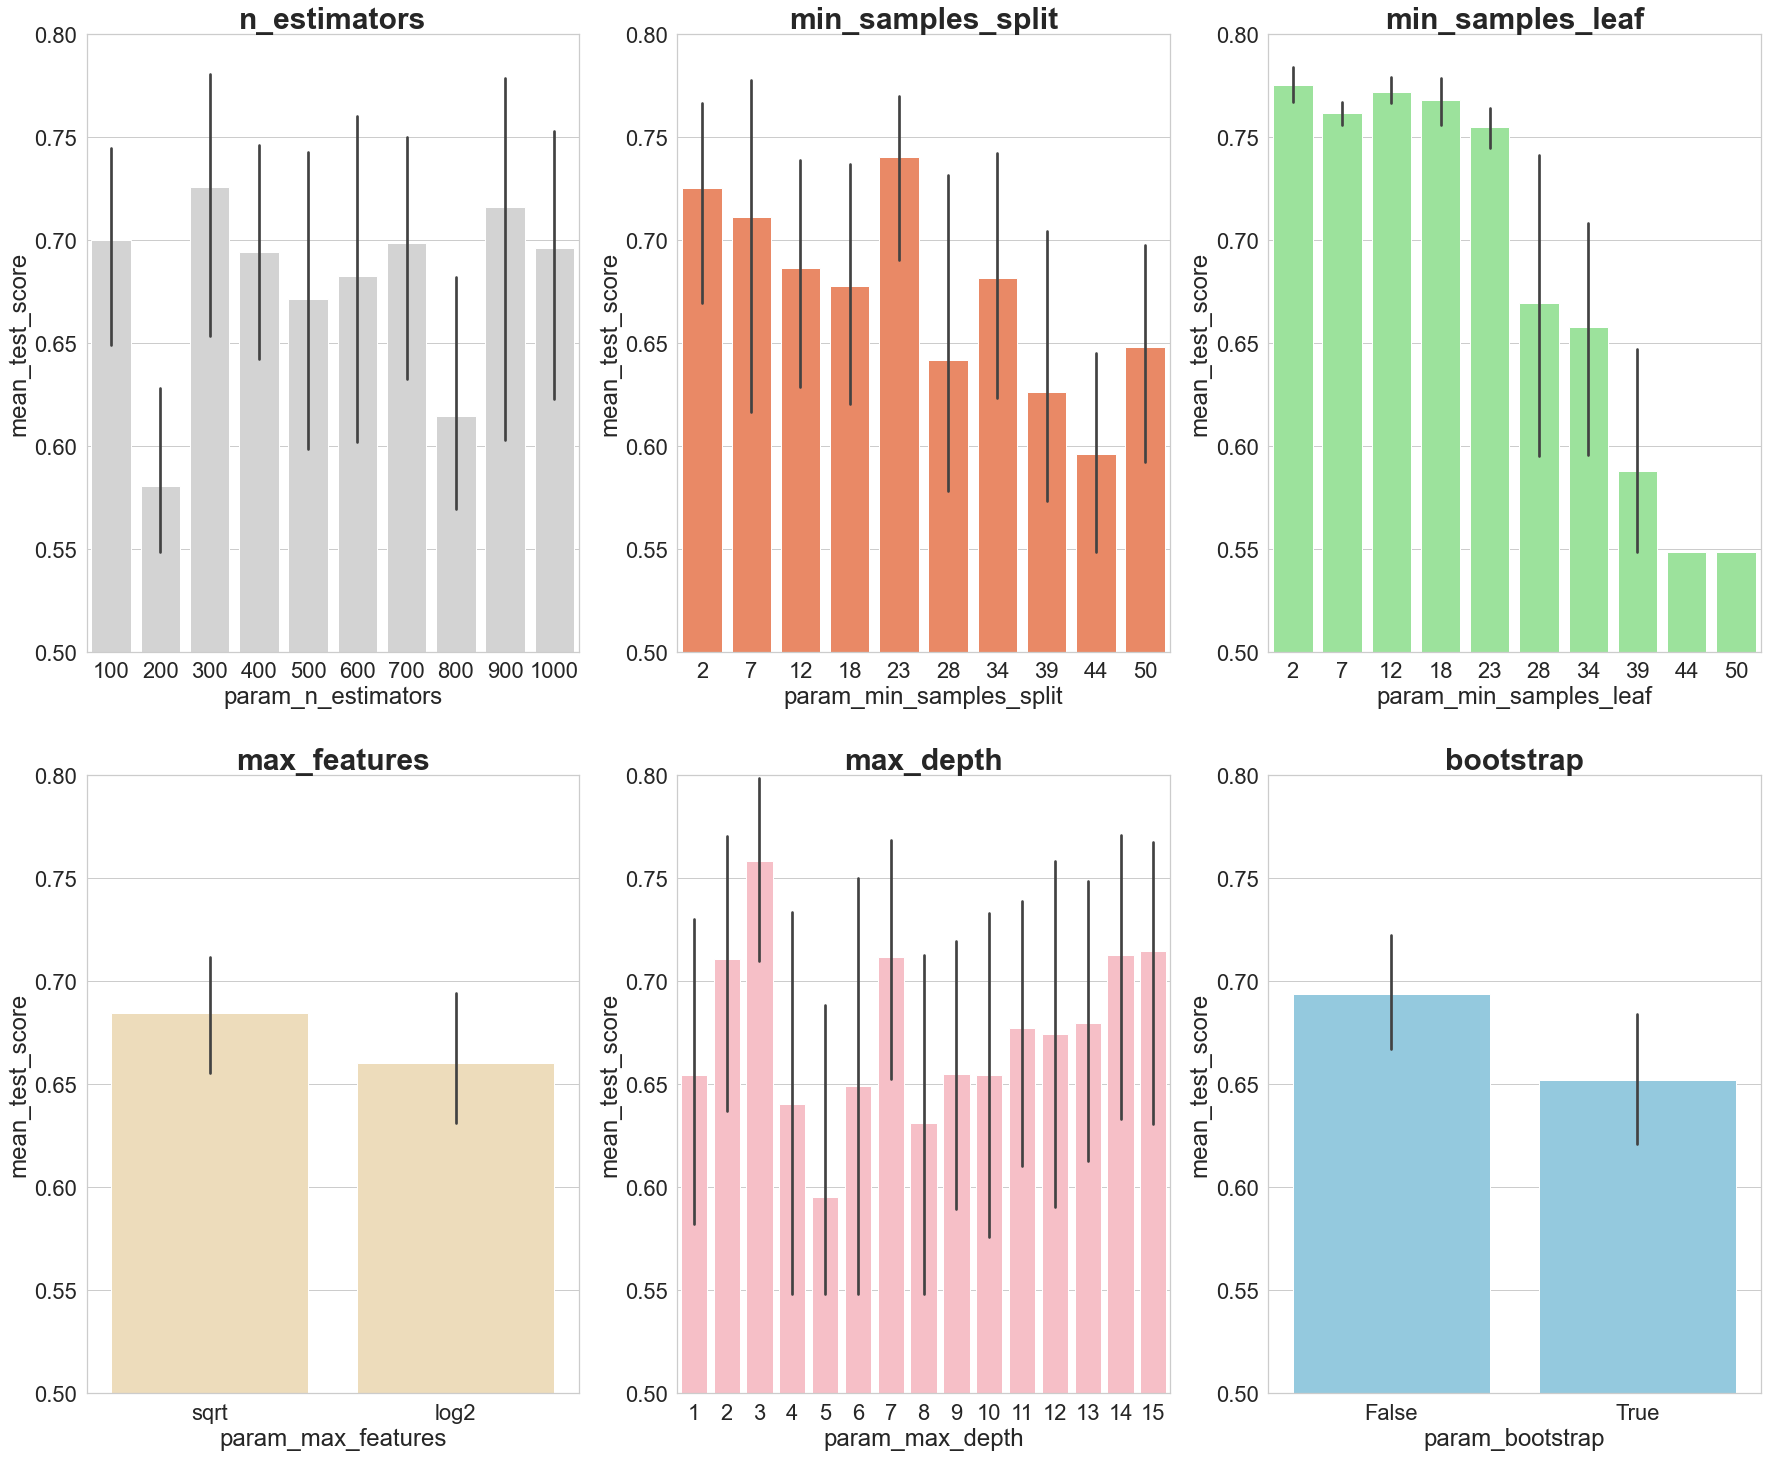

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.50,.80])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.50,.80])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.50,.80])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.50,.80])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.50,.80])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.50,.80])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Оптимальные значения:
n_estimators = [100, 300, 700, 900]
min_samples_split = [2, 7, 12, 23, 34]
min_samples_leaf = [2, 7, 12, 18, 23]
max_features = 'sqrt'
max_depth = [2, 3, 7, 14, 15]
bootstrap = False

In [80]:
#Оптимизация гиперпараметров
'''
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_depth': 3,
 '''
model_2 = RFC(n_estimators=10, criterion="gini", min_samples_split=12, min_samples_leaf=2, max_depth=3)
model_2.fit(X_train_scaled, y_train)
y_pred = model_2.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7380952380952381

model_21 = RFC(n_estimators=10, criterion="entropy", min_samples_split=12, min_samples_leaf=2, max_depth=3)
model_21.fit(X_train_scaled, y_train)
y_pred = model_21.predict(X_test_scaled)
print(f"Entropy accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7619047619047619


Gini accuracy score is: 0.7380952380952381
Entropy accuracy score is: 0.7619047619047619


In [84]:
#Добавим узлов

model_3 = RFC(n_estimators=100, criterion="gini", min_samples_split=12, min_samples_leaf=2, max_depth=3)
model_3.fit(X_train_scaled, y_train)
y_pred = model_3.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7619047619047619

model_31 = RFC(n_estimators=100, criterion="entropy", min_samples_split=12, min_samples_leaf=2, max_depth=3)
model_31.fit(X_train_scaled, y_train)
y_pred = model_31.predict(X_test_scaled)
print(f"Entropy accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7857142857142857


Gini accuracy score is: 0.7619047619047619
Entropy accuracy score is: 0.7857142857142857


In [100]:
# min_samples_split=2
#Лучший Accuracy score у gini
model_4 = RFC(n_estimators=100, criterion="gini", min_samples_split=2, min_samples_leaf=2, max_depth=3)
model_4.fit(X_train_scaled, y_train)
y_pred = model_4.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7380952380952381

model_41 = RFC(n_estimators=100, criterion="entropy", min_samples_split=2, min_samples_leaf=2, max_depth=3)
model_41.fit(X_train_scaled, y_train)
y_pred = model_31.predict(X_test_scaled)
print(f"Entropy accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7619047619047619

Gini accuracy score is: 0.7380952380952381
Entropy accuracy score is: 0.7619047619047619


Луший подбор для Entropy:

n_estimators=100, criterion="entropy", min_samples_split=12, min_samples_leaf=2, max_depth=3

# Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.

More information here Gentle introduction to Grid and Random search and here Detailed Explanation with code examples.


Task 3 (1 point). Compare your previous results with GridSearch hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [85]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 700, 900]
max_features = ['sqrt']
max_depth = [2, 3, 7, 14, 15]
min_samples_split = [2, 7, 12, 23, 34]
min_samples_leaf = [2, 7, 12, 18, 23]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

'''
{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}
'''

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


"\n{'bootstrap': False,\n 'max_depth': 15,\n 'max_features': 'sqrt',\n 'min_samples_leaf': 2,\n 'min_samples_split': 4,\n 'n_estimators': 300}\n"

In [94]:
#Лучший Accuracy score у gini
model_gs = RFC(n_estimators=300, criterion="gini", min_samples_split=4, min_samples_leaf=2, max_depth=15, bootstrap=False, max_features='sqrt')
model_gs.fit(X_train_scaled, y_train)
y_pred_gs = model_gs.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred_gs)}")
#Accuracy score is: 0.7857142857142857

model_gs1 = RFC(n_estimators=300, criterion="entropy", min_samples_split=4, min_samples_leaf=2, max_depth=15, bootstrap=False, max_features='sqrt')
model_gs1.fit(X_train_scaled, y_train)
y_pred_gs1 = model_gs1.predict(X_test_scaled)
print(f"Entropy accuracy score is: {accuracy_score(y_test, y_pred_gs1)}")
#Accuracy score is: 0.7619047619047619



Gini accuracy score is: 0.7619047619047619
Entropy accuracy score is: 0.7619047619047619


In [ ]:
y_pred = rfc.predict(X_test_scaled)
y_pred_pca = rfc.predict(X_test_scaled)
y_pred_gs = gs.best_estimator_.predict(X_test_pca)

Task 4 (1 point). And finally tune forest hyperparameters with RandomSearch. Compare results to previous attempts.

In [86]:
#Оптимизация гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100, 300, 700, 900]
max_features = ['sqrt']
max_depth = [2, 3, 7, 14, 15]
min_samples_split = [2, 7, 12, 23, 34]
min_samples_leaf = [2, 7, 12, 18, 23]
bootstrap = [False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled, y_train)
print(rs.best_params_)

'''
'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}
'''


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}


"\n'n_estimators': 300,\n 'min_samples_split': 39,\n 'min_samples_leaf': 18,\n 'max_features': 'log2',\n 'max_depth': 7,\n 'bootstrap': True}\n"

In [88]:
# model_RS
model_RS = RFC(n_estimators=100, criterion="gini", min_samples_split=2, min_samples_leaf=2, max_depth=7, max_features='sqrt', bootstrap=False)
model_RS.fit(X_train_scaled, y_train)
y_pred = model_RS.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.7380952380952381


Gini accuracy score is: 0.7380952380952381


In [89]:
# model_RS_entropy
model_RS_e = RFC(n_estimators=100, criterion="entropy", min_samples_split=2, min_samples_leaf=2, max_depth=7, max_features='sqrt', bootstrap=False)
model_RS_e.fit(X_train_scaled, y_train)
y_pred = model_RS_e.predict(X_test_scaled)
print(f"Gini accuracy score is: {accuracy_score(y_test, y_pred)}")
#Accuracy score is: 0.8095238095238095

Gini accuracy score is: 0.8095238095238095


In [102]:
#Посмотрим на валидационные данные
#Скалируем данные

ss = StandardScaler()
X_val_scaled = ss.fit_transform(X_val)
y_val = np.array(y_val)

y_pred_my_val = model_31.predict(X_val_scaled)
y_pred_gs_val = model_gs.predict(X_val_scaled)
y_pred_Rs_val = model_RS_e.predict(X_val_scaled)

print(f"Entropy accuracy score (жадная подборка) is: {accuracy_score(y_val, y_pred_my_val)}")
print(f"Gini accuracy score (GridSearchCV) is: {accuracy_score(y_val, y_pred_gs_val)}")
print(f"Gini accuracy score (RandomizedSearchCV) is: {accuracy_score(y_val, y_pred_Rs_val)}")

Entropy accuracy score (жадная подборка) is: 0.7857142857142857
Gini accuracy score (GridSearchCV) is: 0.8095238095238095
Gini accuracy score (RandomizedSearchCV) is: 0.8095238095238095


Entropy accuracy score (жадная подборка) is: 0.7857142857142857
Gini accuracy score (GridSearchCV) is: 0.8095238095238095
Gini accuracy score (RandomizedSearchCV) is: 0.8095238095238095

Task 5 (0.5 points). Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

Удобнее конечно использовать RandomSearch или GridSearchCV, ибо самому можно немного запутаться. Ко всему прочему у меня получилось так, что лучшие оценки показали как раз RandomSearch или GridSearchCV

# Desicion tree explained

Remember the Titanic competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of survived / dead labeling?

Task 6 (1 point). Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of DesicionTreeClassifier (use one of the approaches above) in order to have test accuracy more than 0.65.

Draw the best tree decision making process. You may use sklearn.tree.prot_tree.

In [103]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [104]:
PATH = "./data_titanic/"
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [105]:
#Categorical Features
data['Pclass'] = data['Pclass'].map(data.groupby('Pclass').size())
data['Sex'] = data['Sex'].map(data.groupby('Sex').size())
data['Embarked'] = data['Embarked'].map(data.groupby('Embarked').size())

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
for feat in features:
    data.fillna({feat: data[feat].mean()}, inplace=True)

data[features]

,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,
1,491,577,22.000000,1,0,644.0
2,216,314,38.000000,1,0,168.0
3,491,314,26.000000,0,0,644.0
4,216,314,35.000000,1,0,644.0
5,491,577,35.000000,0,0,644.0
...,...,...,...,...,...,...
887,184,577,27.000000,0,0,644.0
888,216,314,19.000000,0,0,644.0
889,491,314,29.699118,1,2,644.0


In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['Survived'], test_size=0.2, random_state=1)

In [107]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
X_prediction = clf.predict(X_train)

print(f'Train : {clf.score(X_train, y_train):.3f}')


Train : 0.954


In [108]:
print(f'Test : {clf.score(X_test, y_test):.3f}')
#Test : 0.777

Test : 0.788


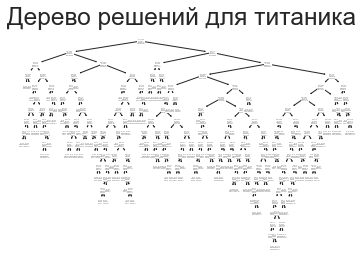

In [123]:
from sklearn import tree
import matplotlib.pyplot as plt 

tree.plot_tree(clf.fit(X_train, y_train))
plt.suptitle("Дерево решений для титаника")
plt.savefig('tree_titanic', dpi=100)
#Очень маленькое разрешение, поэтому сохраним картинку


Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

Сложно рассмотреть само дерево решений из-за разрешения, но сама  идея решения задач с помощью деревьев довольно проста в использовании (я имею в виду само дерево, структура). Используя эту структуру, в принципе не сложно сделать предсказания, например, выживаемость на титанике

# Homework part 2. RandomForestRegressor

Task 7 (2 points). Write your own DecisionTreeRegressor class with MSE split criterion and settable parameter max_depth. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with sklearn.tree.DecisionTreeRegressor.

Provide examples for different _maxdepth parameter.

Of course you may re-use code for DecisionTreeClassifier. You need to figure out what needs to be changed in it for Classification -> Regression transformation.

! You are allowed to use only NumPy library in this assigment.

In [ ]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

Task 8 (2 points). Write your own RandomForestRegressor class with MSE split criterion and settable parameter _maxdepth. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with sklearn.ensemble.RandomForestRegressor.

Provide examples for different max_depth parameter.

! You are allowed to use only NumPy library in this assigment.

In [ ]:
class RandomForestRegressor(object):
    '''
    '''
    def __init__(self,
                 n_estimators=10,
                 criterion="mse",
                 n_features=None,
                 max_depth=None,
                 bootstrap=True,
                 random_state=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
    def fit(self, X, y=None, sample_weight=None):
        """
        Fit estimator.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Use ``dtype=np.float32`` for maximum
            efficiency. Sparse matrices are also supported, use sparse
            ``csc_matrix`` for maximum efficiency.

        y : Ignored
            Not used, present for API consistency by convention.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.

        Returns
        -------
        self : object

        """
        self.fit_transform(X, y, sample_weight=sample_weight)
        return self
    
    def fit_transform(self, X, y=None, sample_weight=None):
        """
        Fit estimator and transform dataset.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Input data used to build forests. Use ``dtype=np.float32`` for
            maximum efficiency.

        y : Ignored
            Not used, present for API consistency by convention.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.

        Returns
        -------
        X_transformed : sparse matrix of shape (n_samples, n_out)
            Transformed dataset.
        """
        X = check_array(X, accept_sparse=['csc'])
        if issparse(X):
            # Pre-sort indices to avoid that each individual tree of the
            # ensemble sorts the indices.
            X.sort_indices()

        rnd = check_random_state(self.random_state)
        y = rnd.uniform(size=X.shape[0])
        super().fit(X, y, sample_weight=sample_weight)

        self.one_hot_encoder_ = OneHotEncoder(sparse=self.sparse_output)
        return self.one_hot_encoder_.fit_transform(self.apply(X))
    
    def _accumulate_prediction(predict, X, out, lock):
    """
    This is a utility function for joblib's Parallel.

    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """
    prediction = predict(X, check_input=False)
    with lock:
        if len(out) == 1:
            out[0] += prediction
        else:
            for i in range(len(out)):
                out[i] += prediction[i]
    
   
    

# Homework part 3 (bonus). Speeding up forest training process

Task 9 (3 points) Devise a way to speed up training against the default version of our custom RandomForestClassifier or your own RandomForestRegressor. You may want use joblib for parallelizing trees training. Provide graphs of time dependences on the number of trees in your fast version with different number of cores / threads used against default one.

In [ ]:
# Your code here